## Corona Virus Ecuador

**Lenin G. Falconi**

**Marzo 20, 2020**

Para los cálculos presentados a continuación se considera como base:

https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d



### Data
La data utilizada es la proporcionada por la posta en una gráfica publicada con datos hasta 18 marzo.

### Objectivos:
* Aproximar un modelo de regresión logística para el comportamiento de contagio sin control en Ecuador
* Aproximar modelos de otros países. Para interpolar a los datos locales. 
* Modelar considerando como el número de hospitales, número de respiradores, número de población con movilidad restringida? Para un enfoque de aprendizaje supervisado se require de datos para esta etapa. 
* Corregir los cálculos del primer objetivo considerando el factor movilidad


In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

### Data
Organizo los datos del gráfico de **La Posta** en un archivo csv

In [2]:
os.listdir()

['CoronaVirusEcu.ipynb',
 'coronavirusEcu.csv',
 '.ipynb_checkpoints',
 'coronavirusEcu_formatted.csv']

In [3]:
df = pd.read_csv('coronavirusEcu.csv')
df


,Date,Number_of_Cases
0,2020-02-28,0
1,2020-02-29,1
2,2020-03-01,6
3,2020-03-02,7
4,2020-03-04,10
5,2020-03-05,13
6,2020-03-06,14
7,2020-03-08,15
8,2020-03-10,17
9,2020-03-12,19


Se obtiene el gráfico original de los datos proveídos

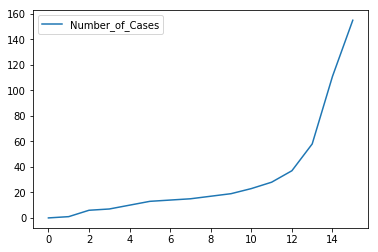

In [4]:
df.plot.line()


En forma similar a la referencia principal se convierte las fechas a números considerando al 1 de enero de 2020 como día 1 del año. Esto se podría replantear considerando más bien al inicio de la infección como el día 1. Posiblemente, por facilidad el autor original ha considerado usar este presupuesto para calcular el día de climax de infección.

In [5]:
FMT = '%Y-%m-%d'
date = df['Date']
df['Date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )
# (datetime.strptime("29/02/2020", FMT)-datetime.strptime("01/01/2020", FMT)).days
df

,Date,Number_of_Cases
0,58,0
1,59,1
2,60,6
3,61,7
4,63,10
5,64,13
6,65,14
7,67,15
8,69,17
9,71,19


Esta nueva tabla de valores se guarda en un nuevo csv para facilidad de uso y verificar los cálculos en otras herramientas como *Matlab*

In [6]:
df.to_csv('coronavirusEcu_formatted.csv')

Extracción de los datos en variables $x$ y  $y$, para modelar una ecuación paramétrica del tipo $y=f(x)$

In [7]:
y = list(df['Number_of_Cases'].values.tolist())
y

[0, 1, 6, 7, 10, 13, 14, 15, 17, 19, 23, 28, 37, 58, 111, 155]

In [8]:
# x = np.array(df.index.tolist())
# x = df.index.tolist()
x = list(df['Date'])
x

[58, 59, 60, 61, 63, 64, 65, 67, 69, 71, 72, 73, 74, 75, 76, 77]

Se define el modelo logístico de acuerdo a la ecuación presentada en la publicación original. No obstante, esta puede ser reformulada y debería considerar factores atenuantes. La ecuación es:

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

Donde:
* $y$: número de contagiados o casos totales
* $x$: día del año para el que se tiene un valor determinado de contagiados
* $a$: velocidad de infección.
* $b$: día en el que ocurre el máximo de infecciones
* $c$: total de infectados en la población.

In [9]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

Ajuste de curva considerando valores iniciales indicados.

In [11]:
popt, pcov = curve_fit(logistic_model,x,y, p0=[10, 80, 2e4],  method='lm', maxfev=4000)
popt

array([2.45057581e+00, 1.05233526e+02, 1.55915121e+07])

In [12]:
(a_, b_, c_) = popt

Matriz Covariante

In [13]:
np.diag(pcov)

array([6.07977997e-01, 1.98254645e+10, 7.98377306e+23])

Error standard para cada parámetro:

In [14]:
np.sqrt(np.diag(pcov))

array([7.79729438e-01, 1.40802928e+05, 8.93519617e+11])

El error del parámetro $c$ es muy elevado:

In [15]:
errors_values = np.sqrt(np.diag(pcov))
errors_variables = ["a_err", "b_err", "c_err"]
errors_dict = dict(zip(errors_variables, errors_values))
errors_dict

{'a_err': 0.77972943814088,
 'b_err': 140802.9278413902,
 'c_err': 893519617061.2937}

Para los mismos datos se hace una predicción según el ajuste de curva, obteniendo los siguientes valores. Note que no se han redondeado los números a valores enteros.

In [16]:
y_pred = logistic_model(x, *popt)
y_pred

array([6.63890577e-02, 9.98430652e-02, 1.50154830e-01, 2.25819118e-01,
       5.10744270e-01, 7.68112615e-01, 1.15517103e+00, 2.61269704e+00,
       5.90924186e+00, 1.33651662e+01, 2.00999778e+01, 3.02285069e+01,
       4.54608629e+01, 6.83688758e+01, 1.02820304e+02, 1.54631810e+02])

En azul se tiene los datos originales y en la curva naranja la curva ajustada

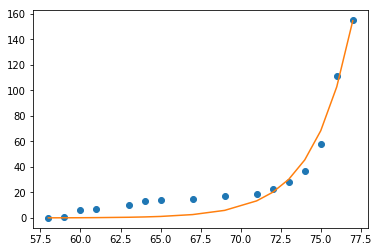

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')

In [18]:
results = {'infection_speed':a_, 'final_day': b_, 'total_infected':c_}

Número total de personas infectadas (en millones):

In [19]:
results['total_infected']/1e6

15.591512116535618

In [20]:
results['total_infected']-errors_dict['c_err']

-893504025549.1771

El pico de infección se obtiene para el día:

In [21]:
sol = int(fsolve(lambda x : logistic_model(x,*popt) - int(c_),b_))
sol

151

La fecha esperada para el pico de infección es:

In [26]:
specific_date = datetime(2020, 1, 1)
new_date = specific_date + timedelta(sol)
print('año:{} mes:{} día: {}'.format(new_date.year, new_date.month, new_date.day))

año:2020 mes:5 día: 31


Cuántos casos se espera para el 20 de marzo de2020?

In [27]:
target_date = datetime(2020, 3, 20)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('fecha objetivo {} corresponde al día {} con respecto al 01/01/20'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)
print('Predicción del número de infecciones: {}'.format(y_day))

fecha objetivo 2020-03-20 00:00:00 corresponde al día 79 con respecto al 01/01/20
Predicción del número de infecciones: 349.7326755331586


Para la fecha de máxima infecciones, cuántas infecciones?

In [28]:
target_date = datetime(2020, 5, 31)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('target date {} corresponds to day # {}'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)/1e6
print('Predicted number of infections: {}'.format(y_day))

target date 2020-05-31 00:00:00 corresponds to day # 151
Predicted number of infections: 15.591511995729325


Por revisar:
* Usar red neuronal para mapear los datos. Generando un overfitting para generar un incremento artificial de datos, teniendo predicciones para intervalos intermedios de tiempo. Con esta data aumentada, realizar nuevamente el ajuste del modelo, ya que la interpretación de los parámetros de la ecuación permite interpretar información últil.

* Entrenar una red considerando datos más abundantes de otro país. No obstante esto genera el problema de que las condiciones de cada país son diferentes y por tanto la respuesta de cada país es diferente. Por tanto, se pensaría en un modelo global que sea la suma de todos. Luego se podría tratar de especializar las últimas capas del modelo en función de la data particular del país al estilo *transfer learning*.
